In [1]:
import navis

In [2]:
# Load example neurons
nl = navis.example_neurons()

In [3]:
# Convert neurons into microns (they are 8nm)
nl_um = nl / (1000 / 8)

# Generate dotprops yourself 
dps = navis.make_dotprops(nl_um, k=5, resample=False)
nbl = navis.nblast(dps[:3], dps[3:])
nbl

,754534424,754538881
1734350788,0.732714,0.769592
1734350908,0.763147,0.753472
722817260,0.742386,0.793638


In [4]:
# Alternatively
nbl = navis.nblast(nl_um[:3], nl_um[3:], k=5)
nbl

,754534424,754538881
1734350788,0.732714,0.769592
1734350908,0.763147,0.753472
722817260,0.742386,0.793638


In [5]:
aba = navis.nblast_allbyall(dps, k=5)
aba

,1734350788,1734350908,722817260,754534424,754538881
1734350788,1.000000,0.745376,0.752172,0.732714,0.769592
1734350908,0.734747,1.000000,0.680395,0.763147,0.753472
722817260,0.773471,0.743139,1.000000,0.742386,0.793638
754534424,0.764972,0.767277,0.714959,1.000000,0.784669
754538881,0.761478,0.753786,0.753204,0.763031,1.000000


In [9]:
aba_mean = (aba + aba.T) / 2

In [15]:
aba_dist = (aba_mean - 1) * -1
aba_dist

,1734350788,1734350908,722817260,754534424,754538881
1734350788,-0.000000,0.259938,0.237178,0.251157,0.234465
1734350908,0.259938,-0.000000,0.288233,0.234788,0.246371
722817260,0.237178,0.288233,-0.000000,0.271327,0.226579
754534424,0.251157,0.234788,0.271327,-0.000000,0.226150
754538881,0.234465,0.246371,0.226579,0.226150,-0.000000


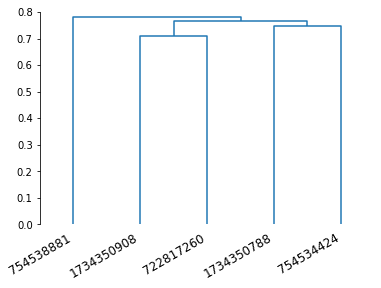

In [25]:
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram

import matplotlib.pyplot as plt
import seaborn as sns

# To generate a linkage, we have to bring the matrix from square-form to vector-form
aba_vec = squareform(aba_mean, checks=False)

# Generate linkage
Z = linkage(aba_vec, method='ward')

# Plot a dendrogram
dn = dendrogram(Z, labels=aba_mean.columns)

ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')

sns.despine(trim=True, bottom=True)